# Example: Center of Mass calculation

Prerequisites: 

 * a python3.6 virtualenv with all requirements installed
  * ``pip install -e .`` in your LiberTEM source dir
  * ``pip install hyperspy hyperspy_gui_ipywidgets`` for additional dependencies
 * a HDF5 dataset in float or double format, with shape ``(256, 256, 128, 128)`` (can use different datasets if you replace the hardcoded values)

In [1]:
%matplotlib nbagg

We disable threading in OpenBLAS because it would interfere with the dask multiprocessing and because OpenBLAS likes to call ``sched_yield`` for no discernable reason

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

Import our dependencies. There may be some warnings about ``hyperspy_gui_traitui`` and so on which can be safely ignored (you do need ``hyperspy_gui_ipywidgets`` though):

In [3]:
from libertem.dataset.hdf5 import H5DataSet
from libertem.executor.dask import DaskJobExecutor
from libertem.job.masks import ApplyMasksJob
from libertem.utils import _make_circular_mask
from scipy.ndimage import measurements
from dask import distributed as dd
import numpy as np
import hyperspy.api as hs
import matplotlib.pyplot as plt

/home/clausen/.virtualenvs/libertem2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Now, we prepare for the actual computation. Center of Mass for a 2D image means multiplying each pixel's intensity with it's position and dividing by the sum of all pixel intensities. We do this separately for ``x`` and ``y`` axis by creating a gradient ``0..127`` for each axis, and a "all ones" mask for the sum of all pixels:

In [4]:
# see also: https://github.com/scipy/scipy/blob/v0.16.1/scipy/ndimage/measurements.py#L1232
x_gradient = np.tile(np.ogrid[slice(0, 128)].astype(np.float32), 128).reshape(128, 128)

masks=[
    # summation of all pixels:
    np.ones(shape=(128, 128)),
    
    # gradient from left to right
    x_gradient,
    
    # transpose() to make gradient from top to bottom:
    x_gradient.transpose(),
]

Now we set up the parameters for the job. If you want to run this notebook, you may need to adjust the ``dataset_path`` variable and ``ds_path`` parameter here. This example uses a local HDF5 file as input dataset, but you can use the HDFS DataSet implementation if you want to use your cluster.

In [5]:
stackheight = 8
dataset_path = "/home/clausen/Data/EMPAD/scan_11_x256_y256.emd"
ds = H5DataSet(
    path=dataset_path,
    ds_path="experimental/science_data/data",
    stackheight=stackheight
)
job = ApplyMasksJob(dataset=ds, masks=masks)
cluster = dd.LocalCluster(threads_per_worker=1)
client = dd.Client(cluster)
executor = DaskJobExecutor(client=client, is_local=True)
# executor = DaskJobExecutor.make_local()

For visualization, we create a HyperSpy signal. For each of our masks, it holds the result values for all scan positions. You can use the slider to switch between masks:

<IPython.core.display.Javascript object>


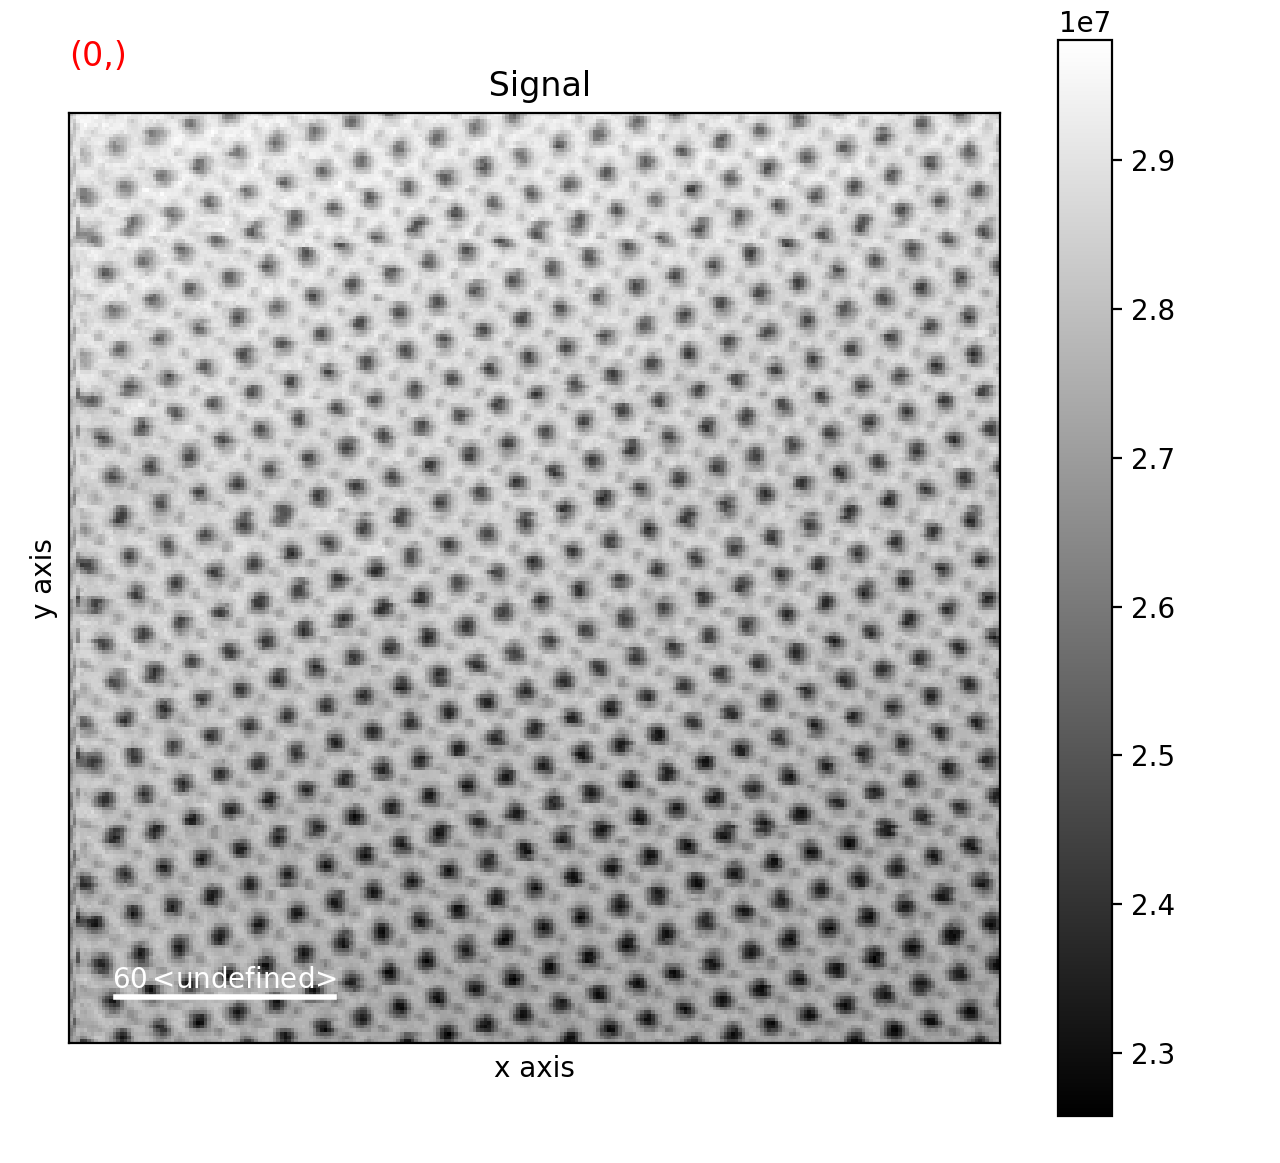

In [6]:
full_result = hs.signals.Signal2D(np.zeros(shape=(job.maskcount, 256, 256)))
full_result.axes_manager[0].name = "masks"
full_result.axes_manager[1].name = "x"
full_result.axes_manager[2].name = "y"
full_result.plot(navigator="slider")

Now, we kick off the computation:

In [7]:
def run():
    for result in executor.run_job(job):
        for tile in result:
            tile.copy_to_result(full_result.data)
    full_result.events.data_changed.trigger(full_result)
%time run()

CPU times: user 355 ms, sys: 163 ms, total: 518 ms
Wall time: 886 ms


Let's create another signal that contains the ``(x, y)`` pairs as signal for each scan position:

In [8]:
x_centers = np.divide(full_result.inav[1].data, full_result.inav[0].data)
y_centers = np.divide(full_result.inav[2].data, full_result.inav[0].data)
centers = hs.signals.Signal1D(np.dstack((x_centers, y_centers)))
centers

<Signal1D, title: , dimensions: (256, 256|2)>

Ok, now that we have our results, let's see how we compare to the ``scipy`` implementation. Let's use HyperSpy to load the dataset lazily (``optimize=False`` because of the lazy signal):

In [9]:
raw_data = hs.load(dataset_path, lazy=True).as_signal2D(image_axes=(0, 1), optimize=False)

Let's have a look at one frame, plot it and see how the result compares to ours:

<IPython.core.display.Javascript object>


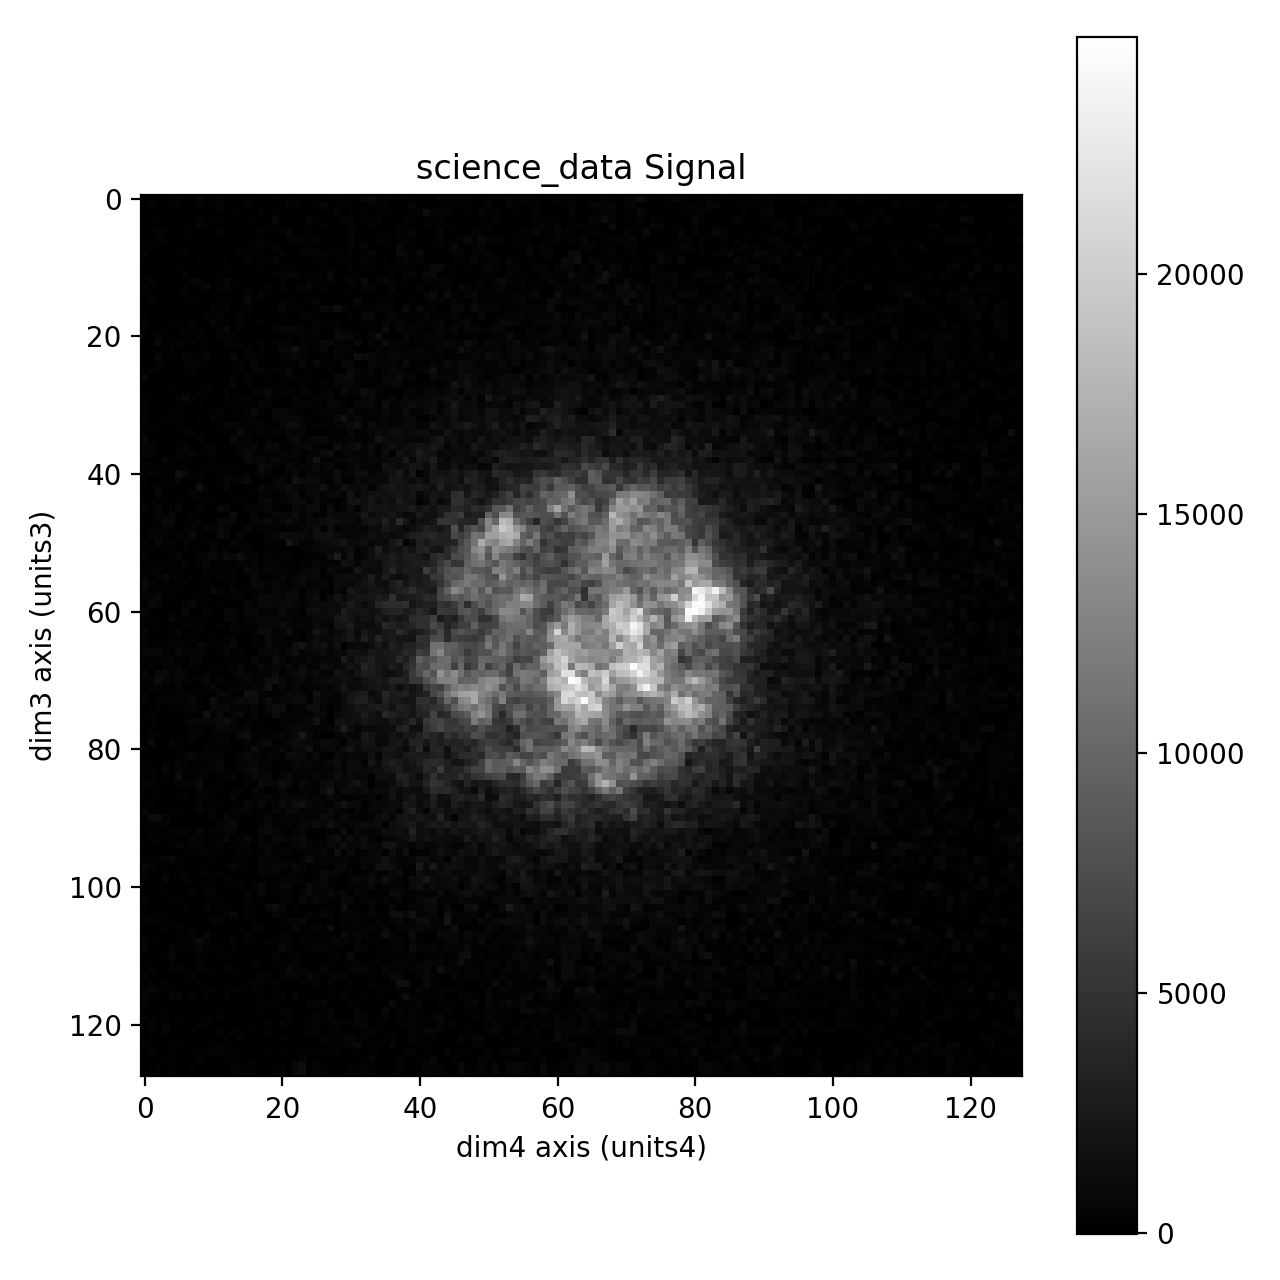

scipy center: x=64.976102, y=64.058465
our center:   x=64.976095, y=64.058463
difference from scipy: x=0.000007, y=0.000002


In [10]:
frame_coords = (64, 64)
frame = raw_data.inav[frame_coords]
frame.plot(navigator=None)
frame_data = frame.data.compute()
center_y, center_x = measurements.center_of_mass(frame_data)
# marker = hs.plot.markers.point(x=center_x, y=center_y, color='red')
# frame.add_marker(marker) # -> crashes for some reason
print("scipy center: x=%.6f, y=%.6f" % (center_x, center_y))
print("our center:   x=%.6f, y=%.6f" % (centers.inav[frame_coords].isig[0].data[0],
                                      centers.inav[frame_coords].isig[1].data[0]))
print("difference from scipy: x=%.6f, y=%.6f" % (
    (center_x - centers.inav[frame_coords].isig[0].data[0]),
    (center_y - centers.inav[frame_coords].isig[1].data[0])
))